In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import chi2
import cython

from KalmanFilter import KalmanFilter
# %load_ext autotime
%load_ext Cython

We'll first estimate the local level model giving us the chance of writing the Kalman filter algorithm which, if there's time, can be re-used for the DSGE model.

# The Model

as described in the chapter 4 in Koopman et al. The local level model with a seasonal component consists of the following equations:

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


We added a $\theta$ coefficient in order to use maximum likelihood estimation

## State Space Form

General Form:

$$ y_t = Z x_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$
$$ x_{t+1} = T x_t + R_t \eta_T, \qquad \eta_t \sim NID(0,Qt) $$

In terms of the model:
$$ 
x_t = 
\begin{pmatrix}\mu_t \\ \gamma_t  \\  \gamma_{t-1}   \\ \gamma_{t-2}  \end{pmatrix}
$$

$$
\eta_t = 
\begin{pmatrix}\xi_t \\ \omega_t \end{pmatrix}
$$

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$


$$
Z^T_t = 
\begin{pmatrix}1 \\ 1  \\  0   \\ 0  \end{pmatrix}
$$

$$
Q_t = 
\begin{bmatrix} 
\sigma^2_\xi & 0 \\
0 & \sigma^2_\omega \\
\end{bmatrix}
$$

$$
R_t = 
\begin{bmatrix} 
1 & 0  \\
0 & 1  \\
0 & 0  \\
0 & 0  \\
\end{bmatrix}
$$

# Generating the data for $\theta_1=1$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 2$$
$$\omega^2_\zeta = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


In [2]:
n = 1000
theta1 = 0.7
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

In [3]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

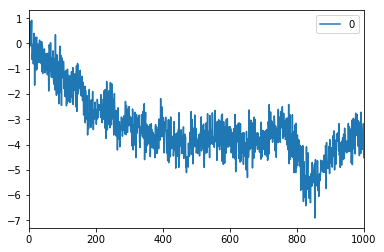

In [4]:
y.plot()

## Filtering States

In [5]:
T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta1],
        [0,1,0,0],
        [0,0,1,0],
    ])
T

,0,1,2,3
0,1,0,0,0.0
1,0,-1,-1,-0.7
2,0,1,0,0.0
3,0,0,1,0.0


In [6]:
Z = pd.DataFrame([
        [1,1,0,0],
    ])
Z

,0,1,2,3
0,1,1,0,0


In [7]:
R = pd.DataFrame([
        [1,0],
        [0,1],
        [0,0],
        [0,0],
    ])
R

,0,1
0,1,0
1,0,1
2,0,0
3,0,0


In [8]:
H = pd.DataFrame([0.3])
H

,0
0,0.3


In [9]:

Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])
Q

,0,1
0,0.1,0.0
1,0.0,0.2


In [10]:
a1 = pd.DataFrame([0,0,0,0])
a1

,0
0,0
1,0
2,0
3,0


In [11]:
P1 = pd.DataFrame(np.diag([1,1,1,1]))
P1

,0,1,2,3
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1


In [12]:
kf = KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4)
kf.runFilter()

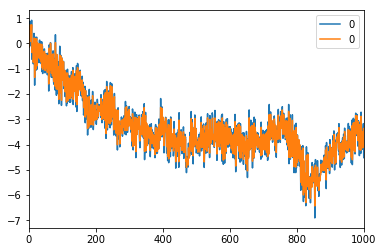

In [13]:
pd.concat([kf.y , kf.yhat],axis=1).plot()

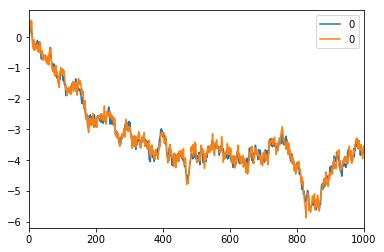

In [14]:
pd.concat([mi , kf.a[0]],axis=1).plot()

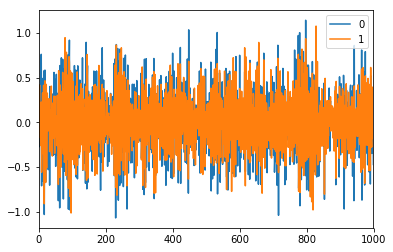

In [15]:
pd.concat([gamma , kf.a[1]],axis=1).plot()

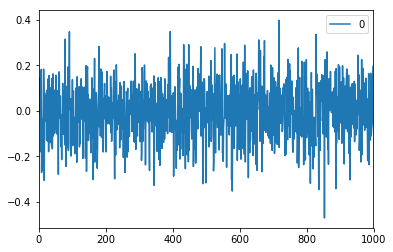

In [16]:
(kf.y-kf.yhat).plot()

# Maximum likelihood estimates

## Generating the data for $\theta_1=0.3$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 2$$
$$\omega^2_\zeta = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


In [100]:
n = 500
theta1 = 0.7
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

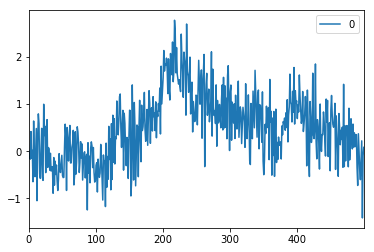

In [101]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

y.plot()

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$



In [102]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([0.3])

    Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])

    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=4)    

    return -np.log(kf.likelihood())


In [103]:
%timeit
KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4).likelihood()

3.3660955695055038e-235

In [105]:
# minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), options={'disp':True, 'maxiter':100}, method='BFGS')

# minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), 
#          options={'disp':True, 'maxiter':200}, 
#          bounds = ((-5,5),(0,5),(0,5),(0,5),), 
#          method='SLSQP',
#          )

minimize(wrapper,np.array([1.0]), 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
#          method='SLSQP',
         )

# minimize(wrapper,np.array([0.0,1.0,1.0]), 
#          options={'disp':True, 'maxiter':1000}, 
#          bounds = ((0,2),(0,2),(0,2),),
#          method='SLSQP')

Optimization terminated successfully.
         Current function value: 537.065296
         Iterations: 4
         Function evaluations: 18
         Gradient evaluations: 6


      fun: 537.0652959909478
 hess_inv: array([[ 0.00282739]])
      jac: array([ 0.])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 0.57593434])

# Bayesian Estimates

## Metropolis Hastings

---
**Metropolis-Hastings Algoritm**

Guess $\theta^{(0)}$ and for $i=0$ until $n$: 
1. $\theta=\theta^{(i)}$
Draw $\theta'\sim q(\theta'|\theta)$
2. Compute $r=\min(1,\alpha)$ where $\alpha= \frac{p(\theta')q(\theta|\theta')}{p(\theta)q(\theta'|\theta)}$
4. Draw $u\sim U(0,1)$
5. $\theta^{(i+1)}=\begin{cases}\theta' & \text{if $u<r$}\\\theta & \text{if $u\geq r$}\end{cases}$

---

In [106]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta],
        [0,1,0,0],
        [0,0,1,0],
    ])

#     H = pd.DataFrame([theta[1]])

#     Q = pd.DataFrame([
#         [theta[2],0],
#         [0,theta[3]],
#     ])

    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=4,
                     performChecks=False)    

    return kf.likelihood()


In [107]:
def wrapperKFUC(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

#     H = pd.DataFrame([theta[1]])

#     Q = pd.DataFrame([
#         [theta[2],0],
#         [0,theta[3]],
#     ])

    kf = KFUC(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=4,
                     performChecks=False)    

    return kf.likelihood()


In [108]:
def posterior(theta,):
    
    i=0
    temp = norm.pdf(theta,0,1)
#     for i in range(1,3+1):
#         temp *= chi2.pdf(theta[i],1)
    
    return wrapper(theta) * temp
#     return temp

In [116]:
sample = 1000

thetas = np.empty(sample+1)
postValues = np.empty(sample+1)
accepted = np.zeros(sample+1)
rs = []
rss = []
thetas[0] = 10

postValues[0] = posterior(thetas[0])
props = []

for i in range(1,sample+1):
    prop = thetas[i-1] + np.random.normal(0,1)
    props.append(prop)
    
    postTemp = posterior(prop,)
#     log_alpha = np.log(postTemp) - np.log(postValues[i-1])
    
#     print(postTemp)
#     r = min(1, np.exp(log_alpha))
    r = min(1, postTemp / postValues[i-1])
#     rss.append(log_alpha)
    rs.append(r)
    u = np.random.uniform()
#     print(u)
    
    if u<r:
        thetas[i] = prop
        accepted[i] = 1
        postValues[i] = postTemp
    else:
        thetas[i] = thetas[i-1]
        postValues[i] = postValues[i-1]



C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: RuntimeWarning: divide by zero encountered in double_scalars


In [117]:
accepted.sum()/sample

0.63400000000000001

In [118]:
burn = 100
thetas = thetas[burn:]

In [119]:
thetas.mean()

9.7167159679773629

In [120]:
np.median(thetas)

6.1376366938349136

In [121]:
sp.stats.mode(thetas)

ModeResult(mode=array([ 0.54736702]), count=array([58]))

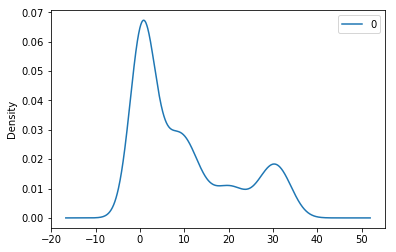

In [122]:
pd.DataFrame(thetas).plot.density()